Authors:
- Abdulaziz Alakooz : Github([@3koozy](https://github.com/3koozy)).
- Ahad Algrais : Github([@ahadalgrais](https://github.com/ahadalgrais)).
- Mujtaba Alghadeer : Github([@ghadeem](https://github.com/ghadeem)).

In [ ]:
#Prequisites:
!pip install torchgeo planetary_computer pystac

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.2/290.2 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 KB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.8/827.8 KB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━

In [ ]:
#Import needed libraries:
import os
import tempfile
from urllib.parse import urlparse
import glob
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import planetary_computer
import pystac
import torch
import torchvision
from torch.utils.data import DataLoader
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler
from torchgeo.datasets import Sentinel2
import rasterio
import shapely
import pyproj
from PIL import Image
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp
import numpy as np

%matplotlib inline

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
!nvidia-smi

Wed Mar 29 03:22:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Custom Satalite Datasets:

## Data Sources and Explorers:

1- **Microsoft Planetry Computer** : provide access to wide varity of satalite imagery sources like sentinel2, landsat 7 & 8 , NAIP , among other. In addition they provide an easy to use API ([See Link](https://planetarycomputer.microsoft.com/catalog)).

2- **Google Earth Engine** : it should provide similar features but we didn't explore this option thourolgy ([See Link](https://earthengine.google.com/)).

3- **sentinel-hub EO Browser** : provide user fiendly GUI to inspect many satalite imagery sources using geo location , ROIs, date, and time. They also provide many cool features such as timelapse and it free to use ([See Link](https://www.sentinel-hub.com/explore/eobrowser/)).

**Note** : almost all satalite imagery sources are provided in GeoTiff ([See Link](https://en.wikipedia.org/wiki/GeoTIFF)) and STAC (SpatioTemporal Asset Catalog / [See Link](https://stacspec.org/en)) formats.

## Explore Microsoft Planetry Computer:

In [ ]:
#Download two tiles selected from MPC explorer (URL and stamp auto generated from MPC):
root = tempfile.mkdtemp()
item_urls = [
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220902T090559_R050_T40XDH_20220902T181115",
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2B_MSIL2A_20220718T084609_R107_T40XEJ_20220718T175008"
]

for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ["B02", "B03", "B04"]:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split("/")[-1]
        download_url(asset_href, root, filename)

  0%|          | 0/197389773 [00:00<?, ?it/s]

  0%|          | 0/192099728 [00:00<?, ?it/s]

  0%|          | 0/186117847 [00:00<?, ?it/s]

  0%|          | 0/198106313 [00:00<?, ?it/s]

  0%|          | 0/195789388 [00:00<?, ?it/s]

  0%|          | 0/193846206 [00:00<?, ?it/s]

In [ ]:
#see downloaded files:
print("Downloaded files : ", sorted(os.listdir(root)))
print("Length of files : ", len(os.listdir(root)))

Downloaded files :  ['T40XDH_20220902T090559_B02_10m.tif', 'T40XDH_20220902T090559_B03_10m.tif', 'T40XDH_20220902T090559_B04_10m.tif', 'T40XEJ_20220718T084609_B02_10m.tif', 'T40XEJ_20220718T084609_B03_10m.tif', 'T40XEJ_20220718T084609_B04_10m.tif']
Length of files :  6


In [ ]:
#Encapsulate downloaded tif files into torchgeo dataset:
#we need to override all_bands , rgb_bands to specify only the downloaded bands:
class Sentinel2_RGB(Sentinel2):
  all_bands = ["B04", "B03", "B02"]
  rgb_bands = ["B04", "B03", "B02"]

#define the dataset:
Sentinel2_RGB_dataset = Sentinel2_RGB(root)

#print dataset info:
print(Sentinel2_RGB_dataset)

Sentinel2_RGB Dataset
    type: GeoDataset
    bbox: BoundingBox(minx=399960.0, maxx=609780.0, miny=8190240.0, maxy=8400000.0, mint=1658133969.0, maxt=1662109559.999999)
    size: 2


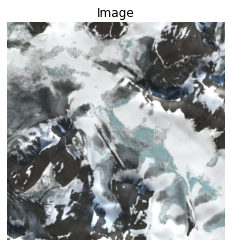

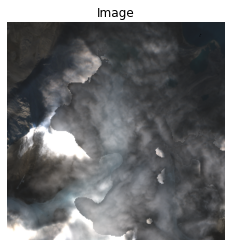

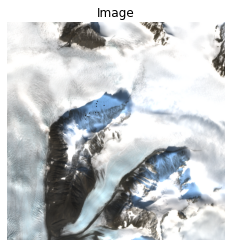

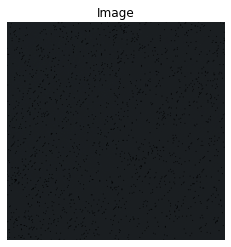

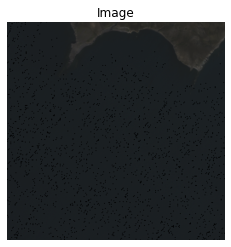

In [ ]:
#print random crops from downloaded dataset:
torch.manual_seed(1)
sampler = RandomGeoSampler(Sentinel2_RGB_dataset, size=512, length=5)
dataloader = DataLoader(Sentinel2_RGB_dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    Sentinel2_RGB_dataset.plot(sample)
    # plot(sample["image"])
    # plot(sample["mask"], image=False)

## Experiment building custom dataset around Riyadh City:

In this experiment we will utlize a scene classification/segmentation layer (SCL) provided by Sentinel2 satalite ([See Link](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview)) with the following labels:

Label /	Classification:
* 0	/ NO_DATA
* 1	/ SATURATED_OR_DEFECTIVE
* 2	/ CAST_SHADOWS
* 3	/ CLOUD_SHADOWS
* 4	/ VEGETATION
* 5	/ NOT_VEGETATED
* 6	/ WATER
* 7	/ UNCLASSIFIED
* 8	/ CLOUD_MEDIUM_PROBABILITY
* 9	/ CLOUD_HIGH_PROBABILITY
* 10	/ THIN_CIRRUS
* 11	/ SNOW or ICE

In [ ]:
#Download two tiles selected from MPC explorer (URL and stamp auto generated from MPC):
root = tempfile.mkdtemp()
item_urls = [
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20230306T072751_R049_T38RPN_20230306T190456" #Riyadh tile
]

for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ["B02", "B03", "B04", "SCL"]:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split("/")[-1]
        download_url(asset_href, root, filename)

  0%|          | 0/230137970 [00:00<?, ?it/s]

  0%|          | 0/232121983 [00:00<?, ?it/s]

  0%|          | 0/226142296 [00:00<?, ?it/s]

  0%|          | 0/393861 [00:00<?, ?it/s]

In [ ]:
#Encapsulate downloaded tif files into torchgeo dataset:
#we need to override all_bands , rgb_bands to specify only the downloaded bands:
class Sentinel2_RGB(Sentinel2):
  all_bands = ["B04", "B03", "B02"]
  rgb_bands = ["B04", "B03", "B02"]

class Sentinel2_SCL(RasterDataset):
  filename_glob = "T*_SCL_20m.tif"
  is_image = False
  separate_files = True
  all_bands = ["SCL"]
  rgb_bands = ["SCL"]

def plot(tensor, image=True):
  if image:
    tensor = torch.clamp(tensor / 10000, min=0, max=1)
  
  plt.figure(figsize=(20, 10))
  plt.imshow(tensor.permute(1, 2, 0))
  cbar = plt.colorbar()
  plt.show()

#define the dataset:
Riyadh_dataset = Sentinel2_RGB(root)
Riyadh_SCL_dataset = Sentinel2_SCL(root, crs=Riyadh_dataset.crs, res=Riyadh_dataset.res)
dataset = Riyadh_dataset & Riyadh_SCL_dataset

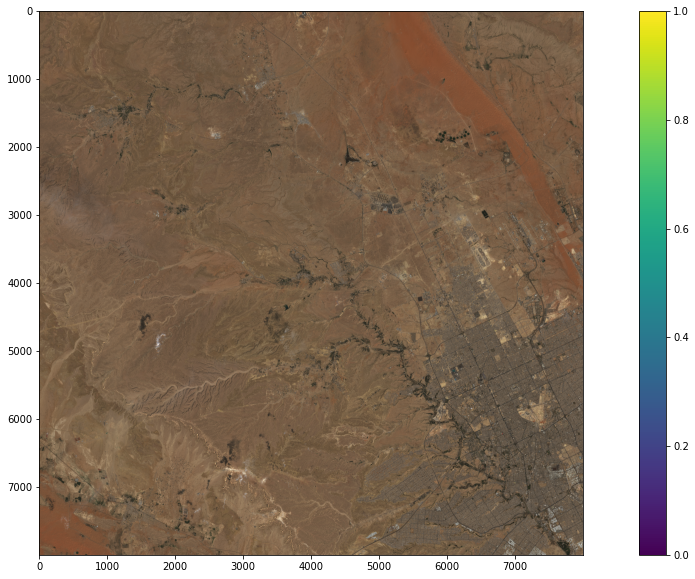

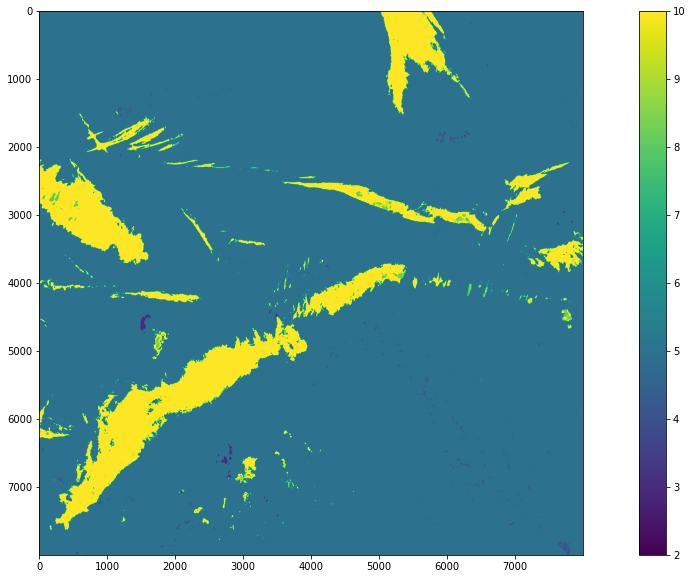

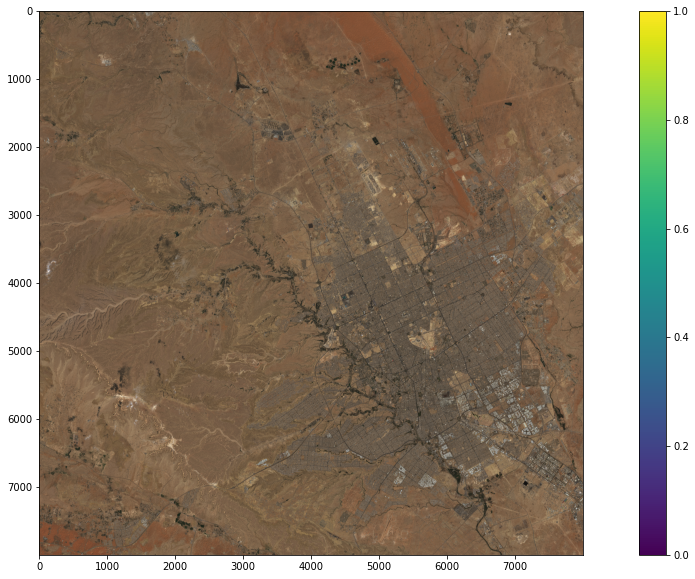

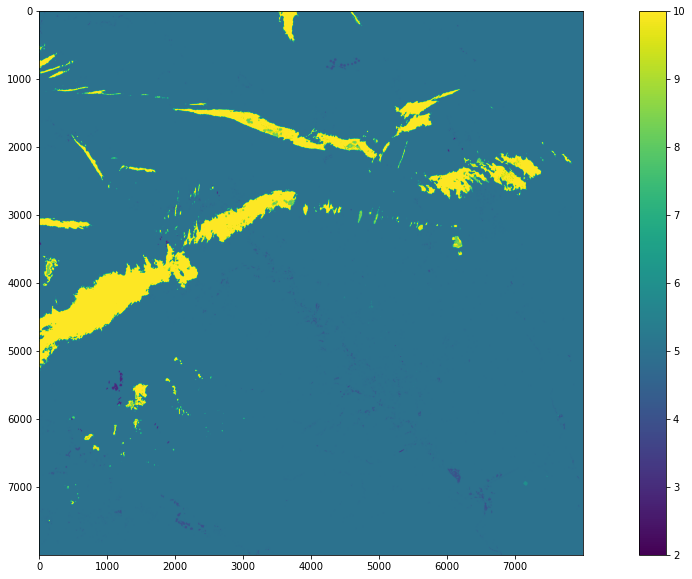

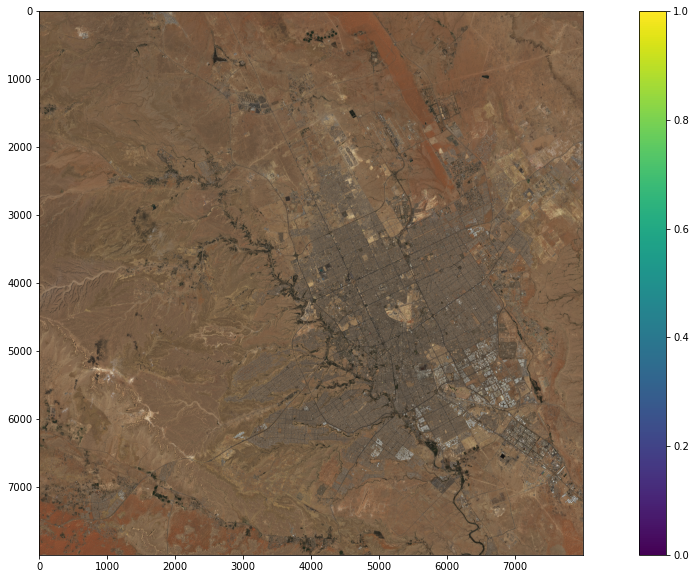

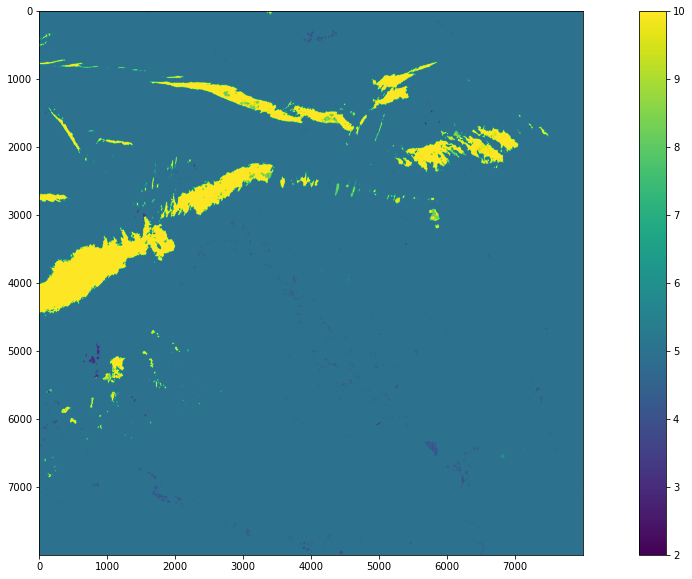

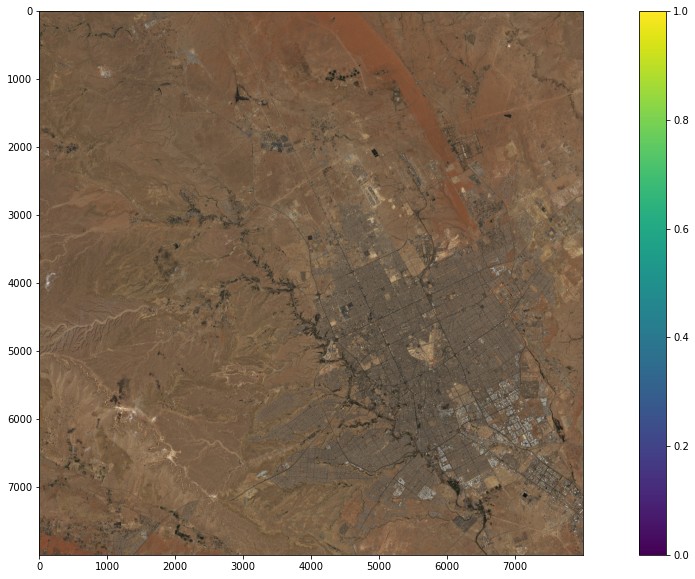

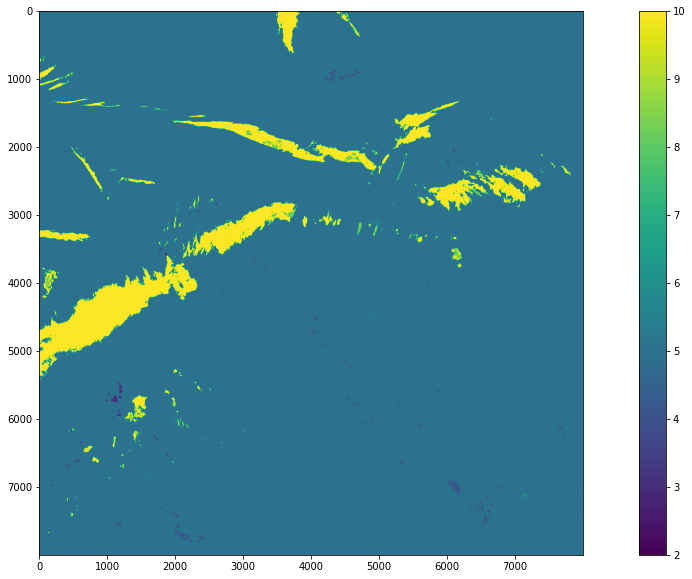

In [ ]:
#print random crops from downloaded dataset:
torch.manual_seed(1)
sampler = RandomGeoSampler(dataset, size=8000, length=4)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)

for batch in dataloader:
    sample = unbind_samples(batch)[0]
    plot(sample["image"])
    plot(sample["mask"], image=False)

From above example , we can see that the particular Sentinel2 tile we chosed (T38RPN) spans a very large area , lots of it is outside of Riyadh City.
We want to accuratley specify a Reigon of intrest (ROI) using geographic coordinates (lat, long).

## Train DL segmentation model on Riyadh city:

In [ ]:
sampler = RandomGeoSampler(dataset, size=256, length=1000)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size=16)

In [ ]:
def acc(label, predicted):
    seg_acc = (y.cpu() == torch.argmax(pred_mask, axis=1).cpu()).sum() / torch.numel(y.cpu())
    return seg_acc

N_EPOCHS = 5

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=12,                      # model output channels (number of classes in your dataset)
)

if str(device) == 'cuda':
        print("model is cuda")
        model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = smp.losses.DiceLoss('multiclass', from_logits=True, ignore_index=0)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
min_loss = torch.tensor(float('inf'))

os.makedirs('./saved_models', exist_ok=True)

model is cuda


In [ ]:
import copy

plot_losses = []
scheduler_counter = 0
best_model = None

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, sample in enumerate(dataloader):
      # sample = unbind_samples(sample)[0]
      x,y = sample["image"][:,:3,:,:], sample["mask"][:,:3,:,:]
      sample=None
      pred_mask = model(x.to(device).float())
      loss = criterion(pred_mask, y.to(device).type(torch.int64))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      print(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(dataloader),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # # testing
  # model.eval()
  # val_loss_list = []
  # val_acc_list = []
  # for batch_i, (x, y) in enumerate(floodnet_dataloader_test):
  #     with torch.no_grad():    
  #         pred_mask = model(x.to(device).float())  
  #     val_loss = criterion(pred_mask, y.to(device).type(torch.int64))
  #     val_loss_list.append(val_loss.cpu().detach().numpy())
  #     val_acc_list.append(acc(y,pred_mask).numpy())
      
  # print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch, 
  #                                                                                                 np.mean(loss_list), 
  #                                                                                                 np.mean(acc_list), 
  #                                                                                                 np.mean(val_loss_list),
  #                                                                                                 np.mean(val_acc_list)))
  # plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  # compare_loss = np.mean(val_loss_list)
  # is_best = compare_loss < min_loss
  # if is_best == True:
  #   scheduler_counter = 0
  #   min_loss = min(compare_loss, min_loss)
  #   torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
  #   best_model = copy.deepcopy(model)

  if scheduler_counter > 5:
      lr_scheduler.step()
      print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
      scheduler_counter = 0

[Epoch 0/5] [Batch 0/63] [Loss: 0.402462 (0.402462)]
[Epoch 0/5] [Batch 1/63] [Loss: 0.391590 (0.397026)]
[Epoch 0/5] [Batch 2/63] [Loss: 0.479808 (0.424620)]
[Epoch 0/5] [Batch 3/63] [Loss: 0.382949 (0.414202)]
[Epoch 0/5] [Batch 4/63] [Loss: 0.289653 (0.389292)]
[Epoch 0/5] [Batch 5/63] [Loss: 0.547664 (0.415688)]
[Epoch 0/5] [Batch 6/63] [Loss: 0.285989 (0.397159)]
[Epoch 0/5] [Batch 7/63] [Loss: 0.294631 (0.384343)]
[Epoch 0/5] [Batch 8/63] [Loss: 0.376297 (0.383449)]
[Epoch 0/5] [Batch 9/63] [Loss: 0.289668 (0.374071)]
[Epoch 0/5] [Batch 10/63] [Loss: 0.195451 (0.357833)]
[Epoch 0/5] [Batch 11/63] [Loss: 0.532146 (0.372359)]
[Epoch 0/5] [Batch 12/63] [Loss: 0.617162 (0.391190)]
[Epoch 0/5] [Batch 13/63] [Loss: 0.539185 (0.401761)]
[Epoch 0/5] [Batch 14/63] [Loss: 0.352571 (0.398482)]
[Epoch 0/5] [Batch 15/63] [Loss: 0.493806 (0.404440)]
[Epoch 0/5] [Batch 16/63] [Loss: 0.286571 (0.397506)]
[Epoch 0/5] [Batch 17/63] [Loss: 0.370588 (0.396011)]
[Epoch 0/5] [Batch 18/63] [Loss: 0.366

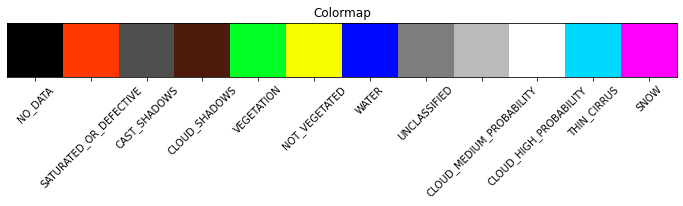

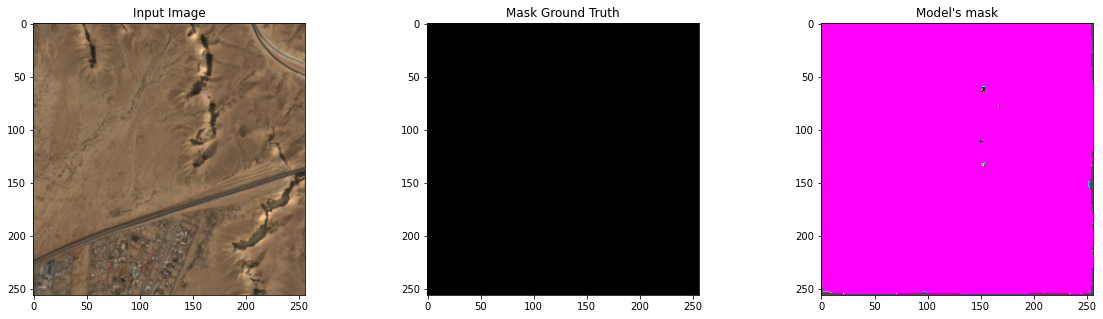

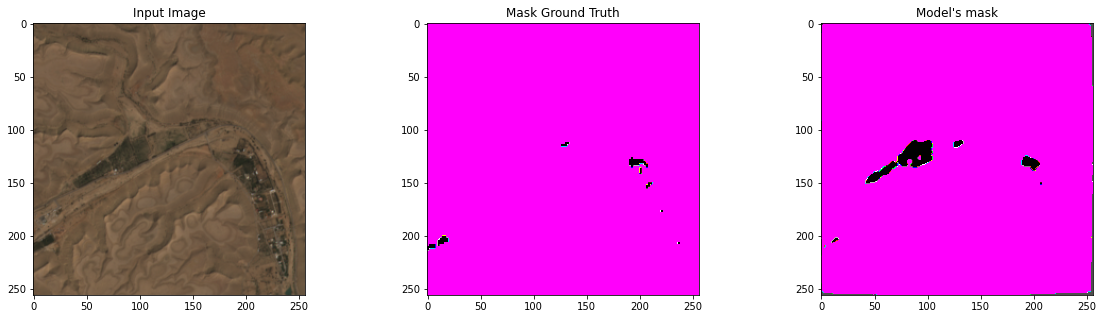

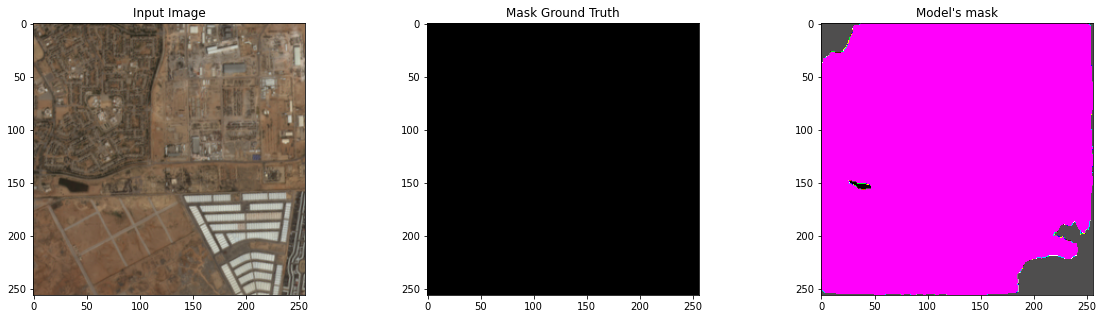

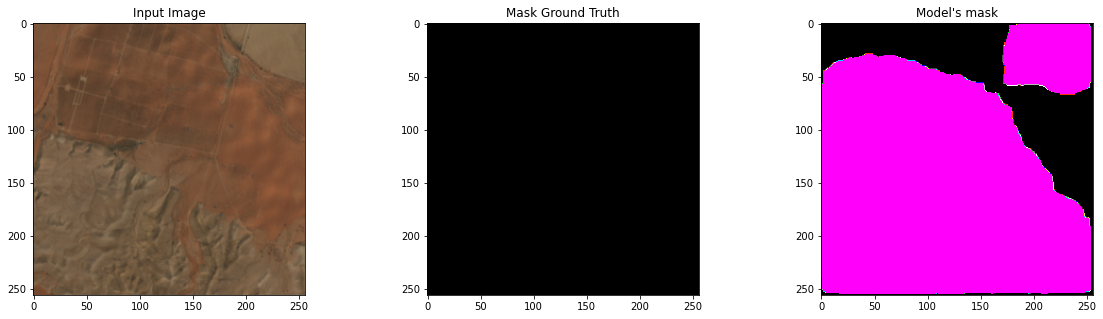

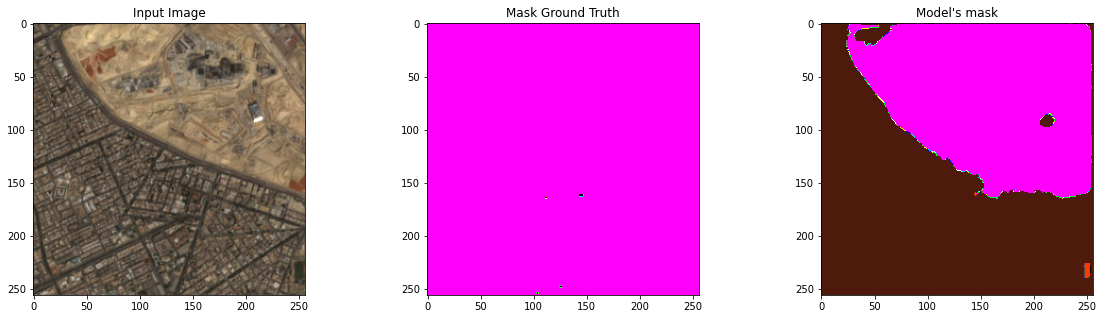

In [ ]:
# lets look at some samples
num_samples = 5
dataloader_plot = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples, batch_size=1)

# Specify colors for each class using hex codes
class_colors = [
    "#000000", "#ff3700", "#4f4e4e", "#4d1a0b",
    "#00ff22", "#f6ff00", "#0008ff", "#7d7d7d",
    "#bababa", "#ffffff", '#00d9ff', '#ff00fb'
]

class_names = [
    'NO_DATA', 'SATURATED_OR_DEFECTIVE', 'CAST_SHADOWS', 'CLOUD_SHADOWS',
    'VEGETATION', 'NOT_VEGETATED', 'WATER', 'UNCLASSIFIED',
    'CLOUD_MEDIUM_PROBABILITY', 'CLOUD_HIGH_PROBABILITY', 'THIN_CIRRUS',
    'SNOW'
]

# Create a colormap with the given colors
colormap = ListedColormap(class_colors)

# Create a seperate figure and plot the colormap
plt.figure(figsize=(12, 1))
plt.imshow(np.arange(12).reshape(1, 12), cmap=colormap, aspect='auto', origin='lower')
plt.xticks(range(12), class_names, rotation=45, fontsize=10)
plt.yticks([])  # Hide y-axis ticks
plt.title("Colormap")
plt.show()

#iterate over samples and display them:
for i in range(num_samples):
    plt.figure(figsize=(20, 5))
    sample = next(iter(dataloader_plot))
    model.eval()
    output = model(sample["image"][:,:3,:,:].float().to(device)).detach().type(torch.int64)
    plt.subplot(1,3,1)
    plt.title("Input Image")
    input_image = sample["image"][:,:3,:,:].squeeze().permute(1, 2, 0).type(torch.int64)
    plt.imshow(torch.clamp(input_image / 10000, min=0, max=1)) # for visualization we have to transpose back to HWC
    plt.subplot(1,3,2)
    plt.title("Mask Ground Truth")
    plt.imshow(sample["mask"][:,:3,:,:].squeeze().type(torch.int64), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    plt.subplot(1,3,3)
    plt.title("Model's mask")
    plt.imshow(output.argmax(dim=1).squeeze().type(torch.int64).cpu(), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    # cbar = plt.colorbar(ticks=range(14), format='%1i', cmap=colormap)
    # cbar.ax.set_yticklabels(class_names)
    
    plt.show()

## Work and Extract specific ROI from geoTiff file:

In [ ]:
#This function allows to only download ROI/geometry data from geoTiff file URL:
def extract_window(path: str, url: str, geometry: shapely.geometry.Polygon) -> None:
    """Extract and write a subset of an image given a geometry and image url."""

    with rasterio.open(url) as ds:
        transform = pyproj.Transformer.from_crs("epsg:4326", ds.crs)
        # polygon to bbox (xyxy)
        bbox = rasterio.features.bounds(geometry)
        # convert bbox to source CRS (xyxy)
        coords = [
            transform.transform(bbox[3], bbox[0]),
            transform.transform(bbox[1], bbox[2]),
        ]
        # convert coords to pixel coords (xyxy)
        pcoords = [
            ds.index(coords[0][0], coords[0][1]),
            ds.index(coords[1][0], coords[1][1]),
        ]
        # convert bbox (xyxy) -> (xxyy)
        bbox_xxyy = ((pcoords[0][0], pcoords[1][0]), (pcoords[0][1], pcoords[1][1]))
        window = rasterio.windows.Window.from_slices(*bbox_xxyy)

        # Copy and update tiff metadata for windowed image
        metadata = ds.meta.copy()
        metadata.update(
            dict(
                height=window.height,
                width=window.width,
                transform=rasterio.windows.transform(window, ds.transform),
                compress="DEFLATE",
            )
        )

        # Write to geotiff
        with rasterio.open(path, "w", **metadata) as ds_windowed:
            ds_windowed.write(ds.read(1, window=window), 1)

#This function normalized input images:
def normalize(x: np.ndarray, scale: float = 2000) -> np.ndarray:
    """Min/max normalize to [0, 1] range given a scale."""
    return np.clip(x / scale, 0, 1)

In [ ]:
#Define ROI (in this case its Rawabi district in Riyadh):
geometry = shapely.geometry.Polygon(
    [
        [46.76553, 24.69492],
        [46.84173, 24.76422],
        [46.85660, 24.69056],
        [46.78486, 24.66608]
    ]
)

In [ ]:
#specify tile URL , and use extract_window function to only download ROI in specifid bands:
root = "/content/"
item_urls = [
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/sentinel-2-l2a/items/S2A_MSIL2A_20230306T072751_R049_T38RPN_20230306T190456"
]

for item_url in item_urls:
    item = pystac.Item.from_file(item_url)
    signed_item = planetary_computer.sign(item)
    for band in ["B04", "B03", "B02"]:
        asset_href = signed_item.assets[band].href
        filename = urlparse(asset_href).path.split("/")[-1]
        # download_url(asset_href, root, filename)
        extract_window(root + filename, asset_href, geometry)

In [ ]:
#combine multiple band file into one file:
files = glob.glob(root + "*.tif")#[os.path.join(root, band) for band in bands]
files = [files[1], files[2], files[0]] #align bands in this order : B4(R) , B3(G), B2(B).

"""Stack separate band files to a single RGBNS image in EPSG:4326 CRS."""
with rasterio.open(files[0]) as ds:
    metadata = ds.meta
    metadata["count"] = len(files)

with rasterio.open(f"{root}image.tif", "w", **metadata) as dst:
    for i, f in enumerate(files, start=1):
        with rasterio.open(f) as src:
            dst.write_band(i, src.read(1))

In [ ]:
#open and inspect combined file:
img = rasterio.open("/content/image.tif")
print("shape : ", img.shape)
print("bands : ", img.count)
print("crs : ", img.crs)

x = img.read()
print("numpy shape : ", x.shape)
img.close()

shape :  (1075, 936)
bands :  3
crs :  EPSG:32638
numpy shape :  (3, 1075, 936)


In [ ]:
x = normalize(x, 10000).astype(np.float32)
x = torch.from_numpy(x)

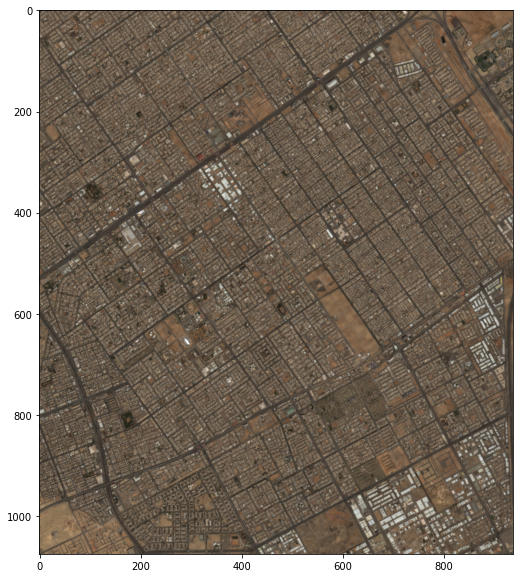

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(x[:3].permute(1, 2, 0))
plt.show()

## Foundation models and data labeling:

1- PEARL Land Cover Mapping ([link here](https://www.landcover.io/)): is a tool for preparing and labeling custome satalite datasets developed by Microsoft providing foundation models which can help you to easily label ROIs. this tool works on NAIP dataset in the US only. they provide fine-tuing option to re-train the foundation model on cusuom labels with no code required.

2- Groundwork ([link here](https://groundwork.azavea.com/)): is a free to use tool which allows team to label GeoTiff/STAC satalite imagery with mature functionalities. multiple Radient ML-Hub datasets used this tool.